## Deep Learning approach: LSTM

In [2]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### LSTM

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [5]:
url1 = ('https://raw.githubusercontent.com/OrangeAVA/Mastering-Time-Series-Analysis-and-Forecasting-with-Python/refs/heads/main/ProductSalesData.csv')

data = pd.read_csv(url1)

data.head()

,Unnamed: 0,Date,Stock Level,Discount,Promotion,Units Sold
0,0,2010-01-01,2381.0,8.506768,Yes,59.0
1,1,2010-01-02,3252.0,9.283937,No,203.0
2,2,2010-01-03,2883.0,9.548446,No,33.0
3,3,2010-01-04,3586.0,9.660054,Yes,117.0
4,4,2010-01-05,3578.0,9.086065,No,71.0


In [6]:
data['Date'] = pd.to_datetime(data['Date'])

data.sort_values('Date', inplace=True)

In [7]:
df = data[['Units Sold']]
df

,Units Sold
0,59.0
1,203.0
2,33.0
3,117.0
4,71.0
...,...
5036,40.0
5037,147.0
5038,231.0
5039,122.0


In [8]:
# Initializes MinMaxScaler to scale values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))  

# Fits the scaler to the data and transforms it into the specified range
df_scaled = scaler.fit_transform(df)  

In [9]:
# Generates input (X) and target (Y) datasets for time series forecasting
def create_dataset(data, ts=1):  
    X, Y = [], []                        # Initialize empty lists to store input features and target values
    
    for i in range(len(data) - ts - 1):  # Iterate over the dataset, stopping before the last 'ts' observations
        a = data[i:(i + ts), 0]          # Extract 'ts' consecutive time steps as input features
        X.append(a)                      # Append the extracted input sequence to X
        Y.append(data[i + ts, 0])        # Append the next time step value as the target output in Y
    
    return np.array(X), np.array(Y)      # Convert lists to NumPy arrays and return them

In [10]:
ts = 3
X, Y = create_dataset(df_scaled, ts)

In [11]:
# Split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(ts, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [15]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
63/63 [==============================] - 3s 20ms/step - loss: 0.0407 - val_loss: 0.0298
Epoch 2/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0300 - val_loss: 0.0292
Epoch 3/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0298 - val_loss: 0.0287
Epoch 4/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0299 - val_loss: 0.0287
Epoch 5/100
63/63 [==============================] - 1s 10ms/step - loss: 0.0297 - val_loss: 0.0286
Epoch 6/100
63/63 [==============================] - 1s 10ms/step - loss: 0.0297 - val_loss: 0.0296
Epoch 7/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0297 - val_loss: 0.0291
Epoch 8/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0296 - val_loss: 0.0285
Epoch 9/100
63/63 [==============================] - 1s 11ms/step - loss: 0.0295 - val_loss: 0.0285
Epoch 10/100
63/63 [==============================] - 1s 9ms/step - loss: 0.0299 - val_loss: 0.0286


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

32/32 [==============================] - 0s 2ms/step


In [18]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [19]:
test_predict

array([[166.5308 ],
       [467.49542],
       [259.6213 ],
       ...,
       [386.69778],
       [468.8954 ],
       [272.81314]], dtype=float32)

In [20]:
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")


Train RMSE: 316.3091096359664, Test RMSE: 311.071360379048


In [21]:
train_predict_plot = np.empty_like(df_scaled)
train_predict_plot[:, :] = np.nan
train_predict_plot[ts:len(train_predict)+ts, :] = train_predict

In [22]:
test_predict_plot = np.empty_like(df_scaled)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(ts):len(df_scaled)-1, :] = test_predict

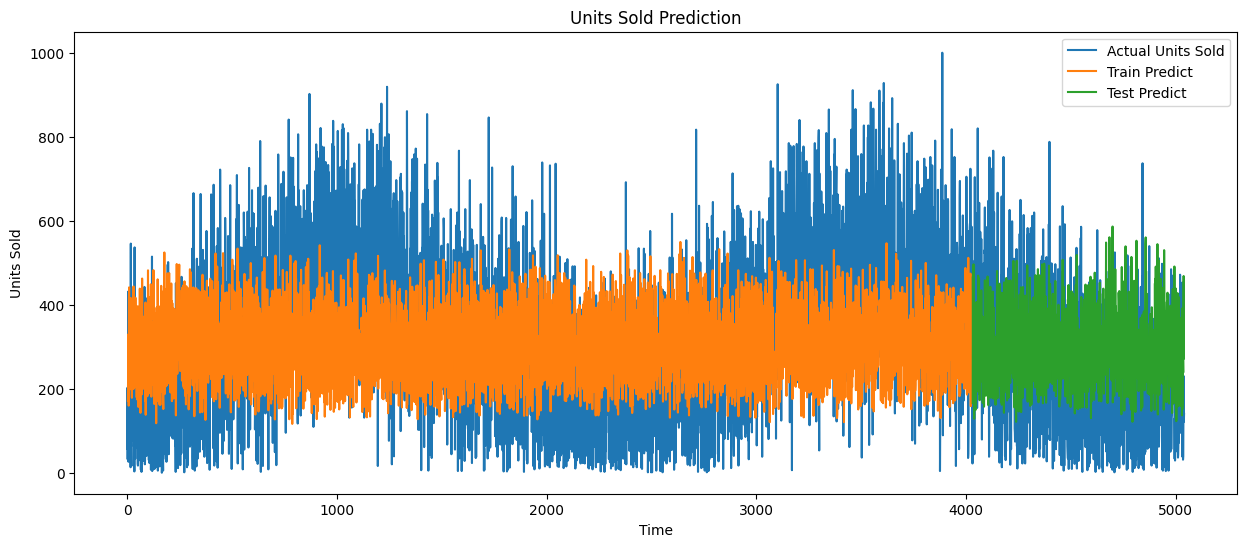

In [23]:
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(df_scaled), label='Actual Units Sold')
plt.plot(train_predict_plot, label='Train Predict')
plt.plot(test_predict_plot, label='Test Predict')
plt.title('Units Sold Prediction')
plt.xlabel('Time')
plt.ylabel('Units Sold')
plt.legend()
plt.show()